# Krótkie wprowadzenie do sieci PFN (Prior-data Fitted Networks)

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor

In [ ]:
class BernoulliPFN(nn.Module):
    def __init__(self, n_features: int, d_emb: int, d_mlp: int, n_head: int, n_layers: int):
        super().__init__()
        self.n_features = n_features

        self.encoder_X = nn.Linear(n_features, d_emb)
        self.encoder_y = nn.Linear(1, d_emb)
        self.decoder = nn.Sequential(nn.Linear(d_emb, d_mlp), nn.GELU(), nn.Linear(d_mlp, 1))
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_emb, n_head, d_mlp, activation="gelu", batch_first=True),
            n_layers,
        )

    def forward(self, X_train: Tensor, y_train: Tensor, X_query: Tensor) -> Tensor:
        """
        Args:
            X_train (Tensor): Shape `(batch_size, n_samples, n_features)`
            y_train (Tensor): Shape `(batch_size, n_samples, 1)`
            X_query (Tensor): Shape `(batch_size, 1, n_features)`

        Returns:
            Tensor: Shape `(batch_size, 1)`
        """
        _, n_samples, n_features = X_train.size()

        assert X_train.ndim == y_train.ndim == X_query.ndim == 3
        assert X_train.size(1) == y_train.size(1)
        assert X_train.size(2) == X_query.size(2)
        assert n_features == self.n_features

        data = self.encoder_X(X_train) + self.encoder_y(y_train)
        query = self.encoder_X(X_query)

        mask = torch.zeros(n_samples + 1, n_samples + 1)
        mask[:-1, -1:] = -torch.inf

        src = torch.cat([data, query], dim=1)
        out = self.transformer(src, mask.to(src))
        out = self.decoder(out)

        return out[:, -1, :]

    @torch.no_grad()
    def predict_proba(self, X_train: Tensor, y_train: Tensor, X_query: Tensor) -> Tensor:
        """
        Args:
            X_train (Tensor): Shape `(n_samples, n_features)`
            y_train (Tensor): Shape `(n_samples, 1)`
            X_query (Tensor): Shape `(query_size, n_features)`

        Returns:
            Tensor: Shape `(query_size, 1)`
        """
        self.eval()
        query_size = X_query.size(0)

        X_train = X_train.expand(query_size, -1, -1)
        y_train = y_train.expand(query_size, -1, -1)
        X_query = X_query.unsqueeze(1)

        logits: Tensor = self(X_train, y_train, X_query)
        return logits.sigmoid()

    def predict(
        self,
        X_train: Tensor,
        y_train: Tensor,
        X_query: Tensor,
        threshold: float = 0.5,
    ) -> Tensor:
        """
        Args:
            X_train (Tensor): Shape `(n_samples, n_features)`
            y_train (Tensor): Shape `(n_samples, 1)`
            X_query (Tensor): Shape `(query_size, n_features)`
            threshold (float): Probability value, used to convert probabilistic outputs into
            concrete class labels.

        Returns:
            Tensor: Shape `(query_size, 1)`
        """
        assert 0.0 < threshold < 1.0
        return self.predict_proba(X_train, y_train, X_query) > threshold

In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.mps.is_available():
    device = "mps"
else:
    device = "cpu"

# device = "cpu"
print(f"Using device: {device.upper()}")

Using device: CUDA


In [46]:
from tqdm import trange
from sklearn.datasets import make_classification, make_blobs

num_epochs = 1_000
batch_size = 256
loss_hist = []

pfn = BernoulliPFN(n_features=2, n_head=8, d_emb=256, d_mlp=512, n_layers=4)
optimizer = torch.optim.Adam(pfn.parameters(), lr=3e-4)

pfn.to(device)
pfn.train()

for epoch in (pbar := trange(num_epochs)):
    # --- Sample a batch of classification tasks from the prior ---
    # data = [make_classification(n_features=2, n_redundant=0) for _ in range(batch_size)]
    data = [make_blobs(n_features=2, centers=2) for _ in range(batch_size)]
    X, y = zip(*data)
    X, y = np.stack(X), np.stack(y)
    X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float().unsqueeze(-1)
    X, y = X.to(device), y.to(device)

    X_train, y_train = X[:, :-1, :], y[:, :-1, :]
    X_query, y_query = X[:, -1:, :], y[:, -1, :]

    # --- Train model ---
    logits = pfn(X_train, y_train, X_query)
    loss = F.binary_cross_entropy_with_logits(logits, y_query)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # --- Log progress ---
    loss_hist.append(loss.item())
    pbar.set_description(f"Epoch {epoch+1:>5d} | Loss {loss.item():.3f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch  1000 | Loss 0.069: 100%|██████████| 1000/1000 [04:29<00:00,  3.71it/s]


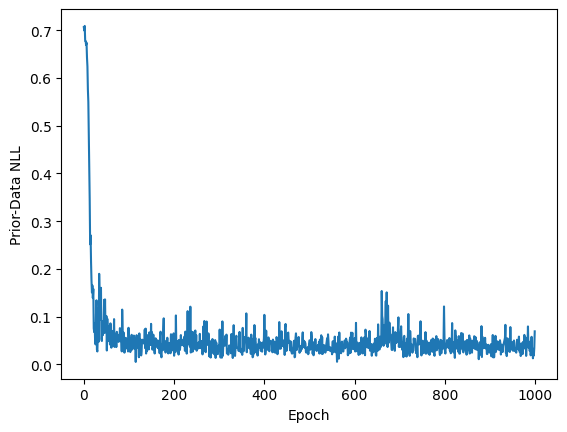

In [47]:
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Prior-Data NLL")
pass

In [48]:
from sklearn import metrics
from sklearn.model_selection import train_test_split

from numpy.typing import NDArray
from matplotlib.lines import Line2D


def evaluate(pfn: BernoulliPFN, data_x: NDArray, data_y: NDArray, device="cpu") -> None:
    pfn.to(device)

    X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, train_size=100)

    X_train = torch.from_numpy(X_train).float().to(device)
    y_train = torch.from_numpy(y_train).float().unsqueeze(-1).to(device)
    X_query = torch.from_numpy(X_test).float().to(device)

    acc = metrics.accuracy_score(y_test, pfn.predict(X_train, y_train, X_query).cpu().numpy().flatten())
    print(f"Accuracy {acc:.2%}")

    # create a mesh to plot in
    x_min, x_max = data_x[:, 0].min() - 1, data_x[:, 0].max() + 1
    y_min, y_max = data_x[:, 1].min() - 1, data_x[:, 1].max() + 1
    h = max(x_max - x_min, y_max - y_min) / 20  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    mesh_query = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float().to(device)

    Z = pfn.predict_proba(X_train, y_train, mesh_query).cpu().numpy()
    Z = Z.reshape(xx.shape)

    _, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.3)
    cs = ax.contour(xx, yy, Z)
    ax.clabel(cs, inline=True, fontsize=8)
    ax.scatter(
        X_train.cpu().numpy()[:, 0],
        X_train.cpu().numpy()[:, 1],
        c=y_train.cpu().numpy().flatten(),
        edgecolors="r",
    )
    ax.scatter(
        X_test[:, 0],
        X_test[:, 1],
        c=y_test,
        edgecolors="k",
    )

    train_handle = Line2D(
        [],
        [],
        marker="o",
        color="w",
        markerfacecolor="none",
        markeredgecolor="r",
        markersize=8,
        label="Train",
    )
    test_handle = Line2D(
        [],
        [],
        marker="o",
        color="w",
        markerfacecolor="none",
        markeredgecolor="k",
        markersize=8,
        label="Test",
    )

    ax.legend(handles=[train_handle, test_handle], loc="best")

    plt.show()

Accuracy 77.50%


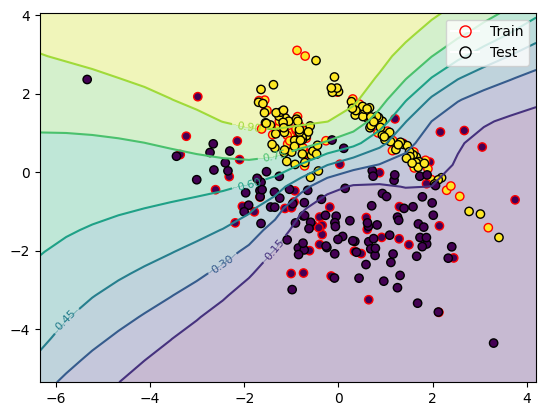

In [51]:
from sklearn.datasets import make_classification

evaluate(pfn, *make_classification(n_samples=300, n_features=2, n_redundant=0), device=device)

Accuracy 81.50%


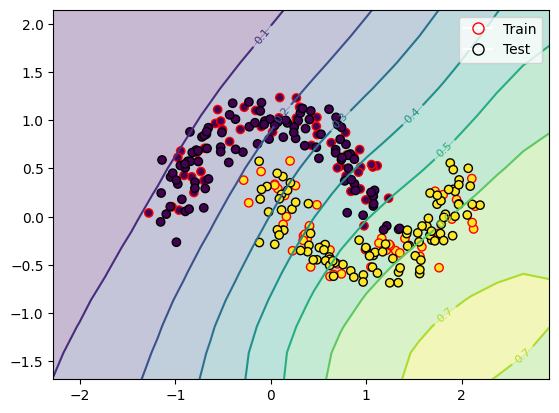

In [53]:
from sklearn.datasets import make_moons

evaluate(pfn, *make_moons(n_samples=300, noise=0.15), device=device)

Accuracy 46.00%


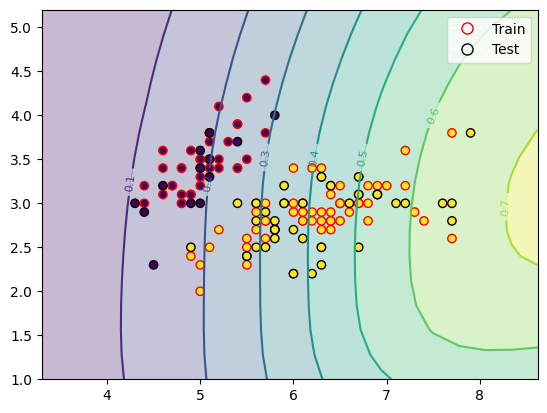

In [81]:
from sklearn.datasets import load_iris

iris = load_iris()
iris.target[iris.target == 2] = 1  # type: ignore
evaluate(pfn, iris.data[:, :2], iris.target, device=device)  # type: ignore

Accuracy 100.00%


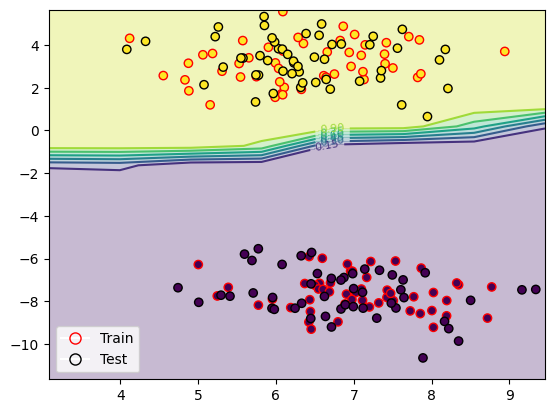

In [76]:
from sklearn.datasets import make_blobs

evaluate(pfn, *make_blobs(n_samples=200, centers=2), device=device)

Accuracy 52.00%


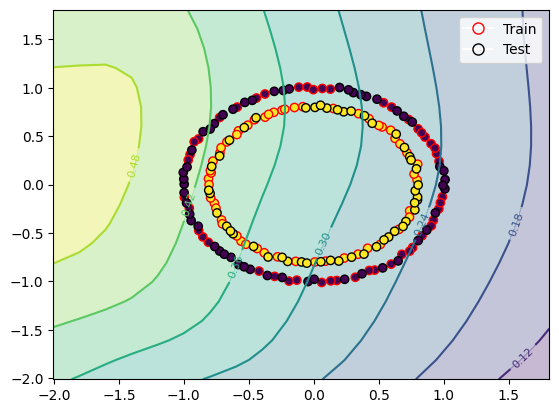

In [77]:
from sklearn.datasets import make_circles

evaluate(pfn, *make_circles(n_samples=200, noise=0.01), device=device)